# Analyzing integration timescales with spectral coherence

In [1]:
%matplotlib inline
import cortex
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import h5py

#### Load language data

In [13]:
path = '/Users/jiamingxu/Desktop/Language_straightenting/data/language/AA_wheretheressmoke.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    # get rid of the first 50 TRs (due to onset effect in AC)
    response_trials = response_trials[:, 50:, :]
    print(response_trials.shape) 

subject, xfm = 'AA', '20180905AA-sg-auto'
mask = cortex.db.get_mask(subject, xfm)

(10, 241, 95556)


#### Load vision data (fixation data)

In [3]:
path = '/Users/jiamingxu/Desktop/Language_straightenting/data/vision_fixation/validation_notavg.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    print(response_trials.shape) 

subject, xfm = 'S1', 'fullhead'
mask = cortex.db.get_mask(subject, xfm)

(900, 32, 100, 100)


## 1. Estimate PSD for each frequency bin

Re-normalize after averaging across repeats for each voxel

In [4]:
avg_reps = np.mean(response_trials,0)
means = np.mean(avg_reps,0)
stds = np.std(avg_reps,0)
norm_avg_reps = (avg_reps - means)/stds
norm_vars = np.var(norm_avg_reps,0)
print("norm var: ",norm_vars)

norm var:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Get PSD

In [15]:
freqs, Pxx = sp.signal.welch(norm_avg_reps, fs=0.5, axis=0, nperseg=64) #language re-normalized
#freqs, Pxx = sp.signal.welch(norm_avg_reps, fs=0.5, axis=0, nperseg=64, noverlap = 56) #vision re-normalized

Notes: averaged across repeats; fs = sampling freq, each data point represents a 2-s interval; axis = 0 the Welch method should
be applied to the first axis of the input array; nperseg = 64 sets the length of each segment in the Welch method
returns 2 arrays: freqs - frequency bins; Pxx - estimates PSD for each frequency bin

#### 1) Plot average PSD of each frequency bin (whole brain)

Text(0, 0.5, 'PSD (W/Hz)')

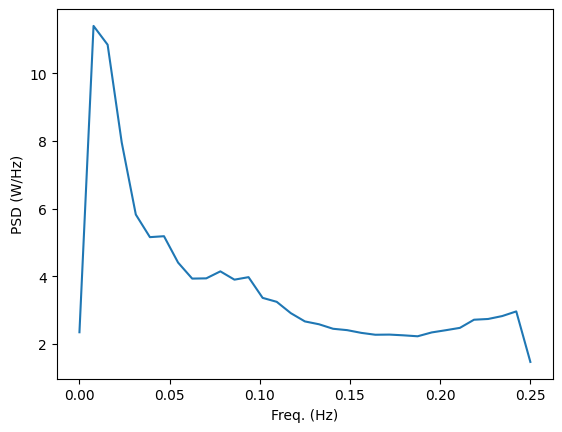

In [16]:
mu_pxx = np.mean(Pxx,axis = 1) # averaged across all voxels
mu_pxx.shape
plt.plot(freqs, mu_pxx.T)

plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')

#### 2) Plot average PSD of each frequency bin (selected ROIs)

In [17]:
# choose functional roi 
#f_rois = ['V1','hMT','FFA']  
f_rois = ['AC','sPMv']
f_roi_voxs = {} # get indices of roi voxels in cortical map
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

Cutting 0 overlapping voxels (should be < ~50)


In [18]:
# choose anatomical roi (PFC & precuneus)
%cd 'data/rois'
a_roi = ['parsopercularis','parstriangularis','superiorfrontal','rostralmiddlefrontal','caudalmiddlefrontal','frontalpole','precuneus']
roi_data = np.load(f'{subject}_roi.npy', allow_pickle=True).item()
a_roi_voxs = {}
for roi in a_roi:
    a_roi_voxs[roi] = roi_data[roi]
    
# combine PFC rois
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]


# combine functional and anatomical
roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

# print number of voxels in each ROI
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

[Errno 2] No such file or directory: 'data/rois'
/Users/jiamingxu/Desktop/Language_straightenting/data/rois
AC: 2124 items
sPMv: 271 items
precuneus: 2845 items
prefrontal: 15222 items


/Users/jiamingxu/miniconda3/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


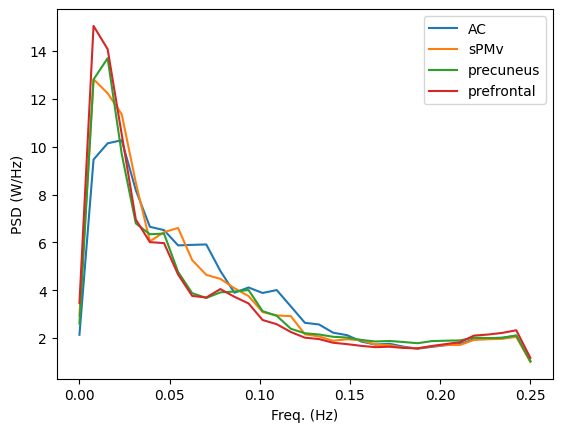

In [19]:
# plot PSD over frequency bins
for roi in roi_voxs:
    mu_roi_pxx = np.mean(Pxx[:,roi_voxs[roi]], axis=1)
    plt.plot(freqs, mu_roi_pxx.T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.legend()

#### 3) Plot center of mass for each frequency spectrum (weighted by PSD) 

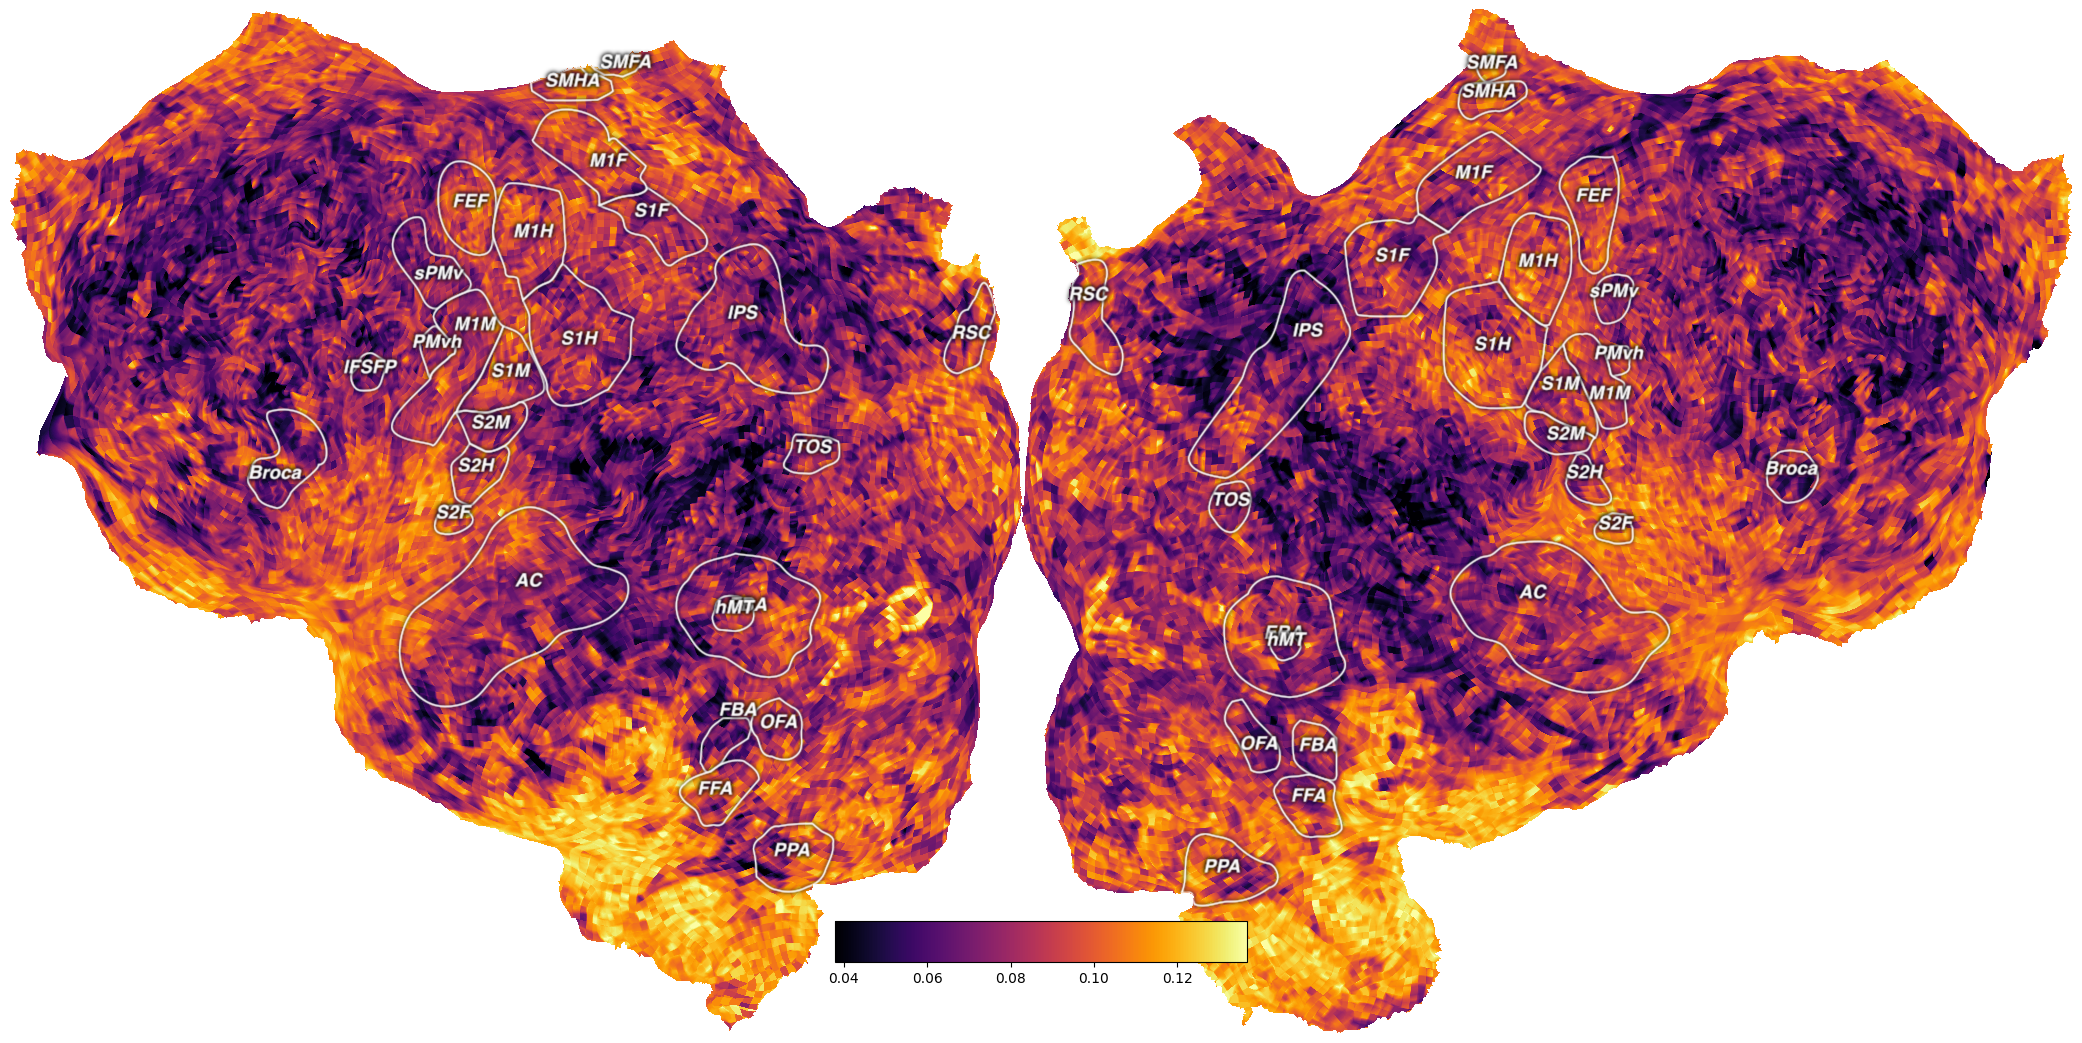

In [20]:
# Plot with pycortex
vol_data = np.average(np.broadcast_to(freqs[:, None], Pxx.shape), weights=Pxx, axis=0) # weighted average of frequency bins by power
vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='inferno')
cortex.quickshow(vol);

In [ ]:
# visualize in 3D
cortex.webshow(vol, port=1420);

## 2. Compute coherence as a measure of SNR

In [21]:
from scipy.signal import welch

def compute_coherence_spectrum(data, fs, nfft=64):
    """Computes the coherency of the voxel's responses across repeats.
    [data] is assumed to be a 2D matrix: repeats x time.
    [Fs] should be the sampling rate of the data (i.e. 0.5 for 2-second TR),
    and NFFT is the number of FFT windows used in the power spectral density estimate.

    From Hsu, Borst, Theunissen 2004, Eq 5
    """
    noverlap = nfft // 2 
    params = dict(nperseg=nfft, fs=fs, noverlap=noverlap)
    
    # compute overall signal (mean across repeats)
    signal = np.mean(data, axis=0)  # (time, voxels)
    
    # compute overall noise (deviation from the mean signal)
    noise = data - signal  # (repeats, time, voxels)
    noise = noise.reshape(-1, data.shape[-1])  # flatten across repeats (repeats * time, voxels)
    
    # compute power spectral density for signal and noise
    freqs, spower = welch(signal, axis=0, **params)
    freqs, npower = welch(noise, axis=0, **params)
    
    # compute jackknifed noise (excluding each trial from the noise computation)
    num_repeats = data.shape[0]
    jnoises = np.zeros_like(data)
    
    for i in range(num_repeats):
        # exclude the i-th repeat and compute the mean of the rest
        idx = np.arange(num_repeats)
        jnoise = data[i,:,:] - np.mean(data[idx != i], axis=0)
        jnoises[i,:,:] = jnoise
    jnoises = jnoises.reshape(-1, data.shape[-1])  # flatten across repeats (repeats * time, voxels)
    
    # compute PSD for jackknifed noise
    freqs, jnpower = welch(jnoises, axis=0, **params)

    coherence_upper = spower/(npower + spower)
    coherence_lower = spower/(jnpower + spower)
    
    return freqs, spower, npower, jnpower, coherence_upper, coherence_lower


#### 1) Compute upper/lower bounds of coherence for all voxels

In [22]:
%%time
freqs, spower, npower, jnpower, coherence_upper, coherence_lower = compute_coherence_spectrum(response_trials, fs=0.5, nfft=64)

CPU times: user 9.33 s, sys: 14.1 s, total: 23.5 s
Wall time: 34.7 s


#### 2) Plot coherence spectrum (averaged across all voxels within each ROI)

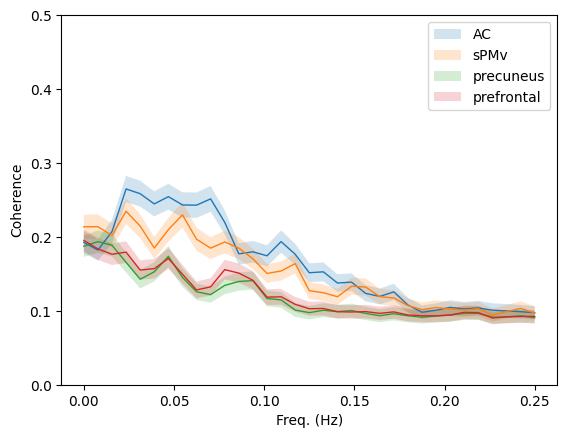

In [24]:
for roi in roi_voxs:
    ub_coherence = np.mean(coherence_upper[:,roi_voxs[roi]], axis=1)
    lb_coherence = np.mean(coherence_lower[:,roi_voxs[roi]], axis=1)
    plt.fill_between(freqs, lb_coherence, ub_coherence, alpha=0.2, label=roi)
    
    mean_coherence = (ub_coherence + lb_coherence) / 2
    plt.plot(freqs, mean_coherence, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.5)  
plt.legend()

#### 3) Find baseline coherence and subtract it out

Break the signals down into 10TR segments, shuffle them around and compute coherence.

In [25]:
# breaking down and shuffling
nRep = response_trials.shape[0]
segment_size = 10  
n_segments = response_trials.shape[1] // segment_size  
shuffled_resps = np.zeros_like(response_trials)

for i in range(nRep):
    segments = np.array_split(response_trials[i, :n_segments * segment_size, :], indices_or_sections=n_segments, axis=0)
    last_segment = response_trials[i, n_segments * segment_size:, :]  
    np.random.shuffle(segments)
    if last_segment.size > 0:  # Only concatenate if the last segment is non-empty
        shuffled_vec = np.concatenate(segments + [last_segment], axis=0)
    else:
        shuffled_vec = np.concatenate(segments, axis=0)
    shuffled_resps[i,:,:] = shuffled_vec

In [26]:
# compute coherence again
freqs, spower_seg, npower_seg, jnpower_seg, coherence_upper_seg, coherence_lower_seg = compute_coherence_spectrum(shuffled_resps, fs=0.5, nfft=64)

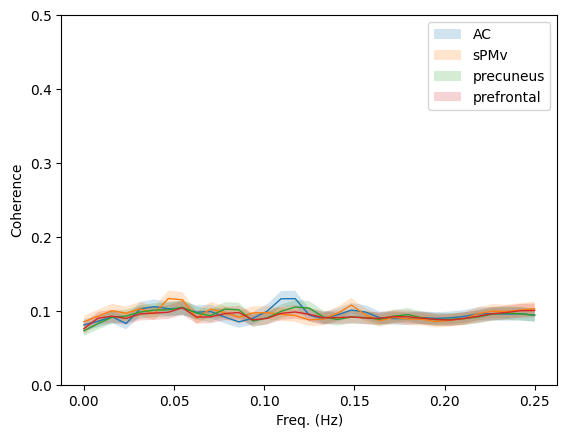

In [27]:
# plot coherence baseline and get mean baseline
baselines = np.zeros((len(roi_voxs), len(freqs)))
idx = 0
for roi in roi_voxs:
    ub_coherence_seg = np.mean(coherence_upper_seg[:,roi_voxs[roi]], axis=1)
    lb_coherence_seg = np.mean(coherence_lower_seg[:,roi_voxs[roi]], axis=1)
    plt.fill_between(freqs, lb_coherence_seg, ub_coherence_seg, alpha=0.2, label=roi)
    
    mean_coherence = (ub_coherence_seg + lb_coherence_seg) / 2
    baselines[idx, :] = mean_coherence
    plt.plot(freqs, mean_coherence, linewidth=1)
    idx += 1

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.5)  
plt.legend()

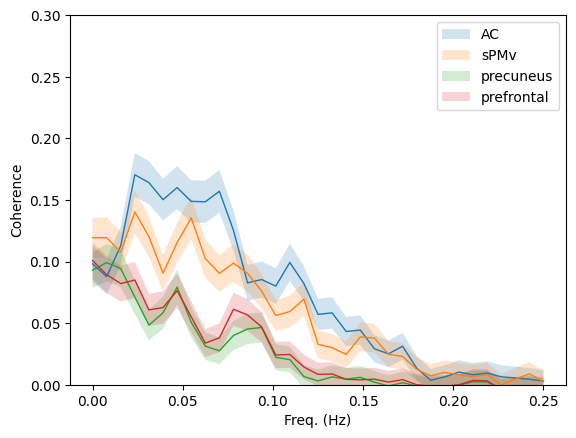

In [28]:
# subtract baseline from real coherence values
mean_baseline = np.mean(baselines)
coherence_upper_denoise = coherence_upper - mean_baseline
coherence_lower_denoise = coherence_lower - mean_baseline
for roi in roi_voxs:
    ub_coherence_denoise = np.mean(coherence_upper_denoise[:,roi_voxs[roi]], axis=1)
    lb_coherence_denoise = np.mean(coherence_lower_denoise[:,roi_voxs[roi]], axis=1)
    plt.fill_between(freqs, lb_coherence_denoise, ub_coherence_denoise, alpha=0.2, label=roi)
    
    mean_coherence_denoise = (ub_coherence_denoise + lb_coherence_denoise) / 2
    plt.plot(freqs, mean_coherence_denoise, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.3)  
plt.legend()

#### 4) normalize, show relative coherence spectrum

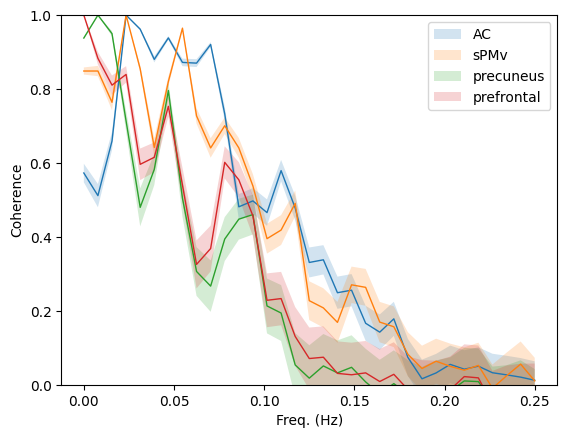

In [32]:
def normalize_by_max(coherence_values):
    return coherence_values / np.max(coherence_values)

for roi in roi_voxs:
    ub_coherence_denoise = np.mean(coherence_upper_denoise[:,roi_voxs[roi]], axis=1)
    lb_coherence_denoise = np.mean(coherence_lower_denoise[:,roi_voxs[roi]], axis=1)

    ub_coherence_norm = normalize_by_max(ub_coherence_denoise)
    lb_coherence_norm = normalize_by_max(lb_coherence_denoise)
    
    plt.fill_between(freqs, lb_coherence_norm, ub_coherence_norm, alpha=0.2, label=roi)
    
    mean_coherence_norm = (ub_coherence_norm + lb_coherence_norm) / 2
    plt.plot(freqs, mean_coherence_norm, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 1)  
plt.legend()
    

#### 5) Plot center of mass for each frequency spectrum (weighted by coherence) 

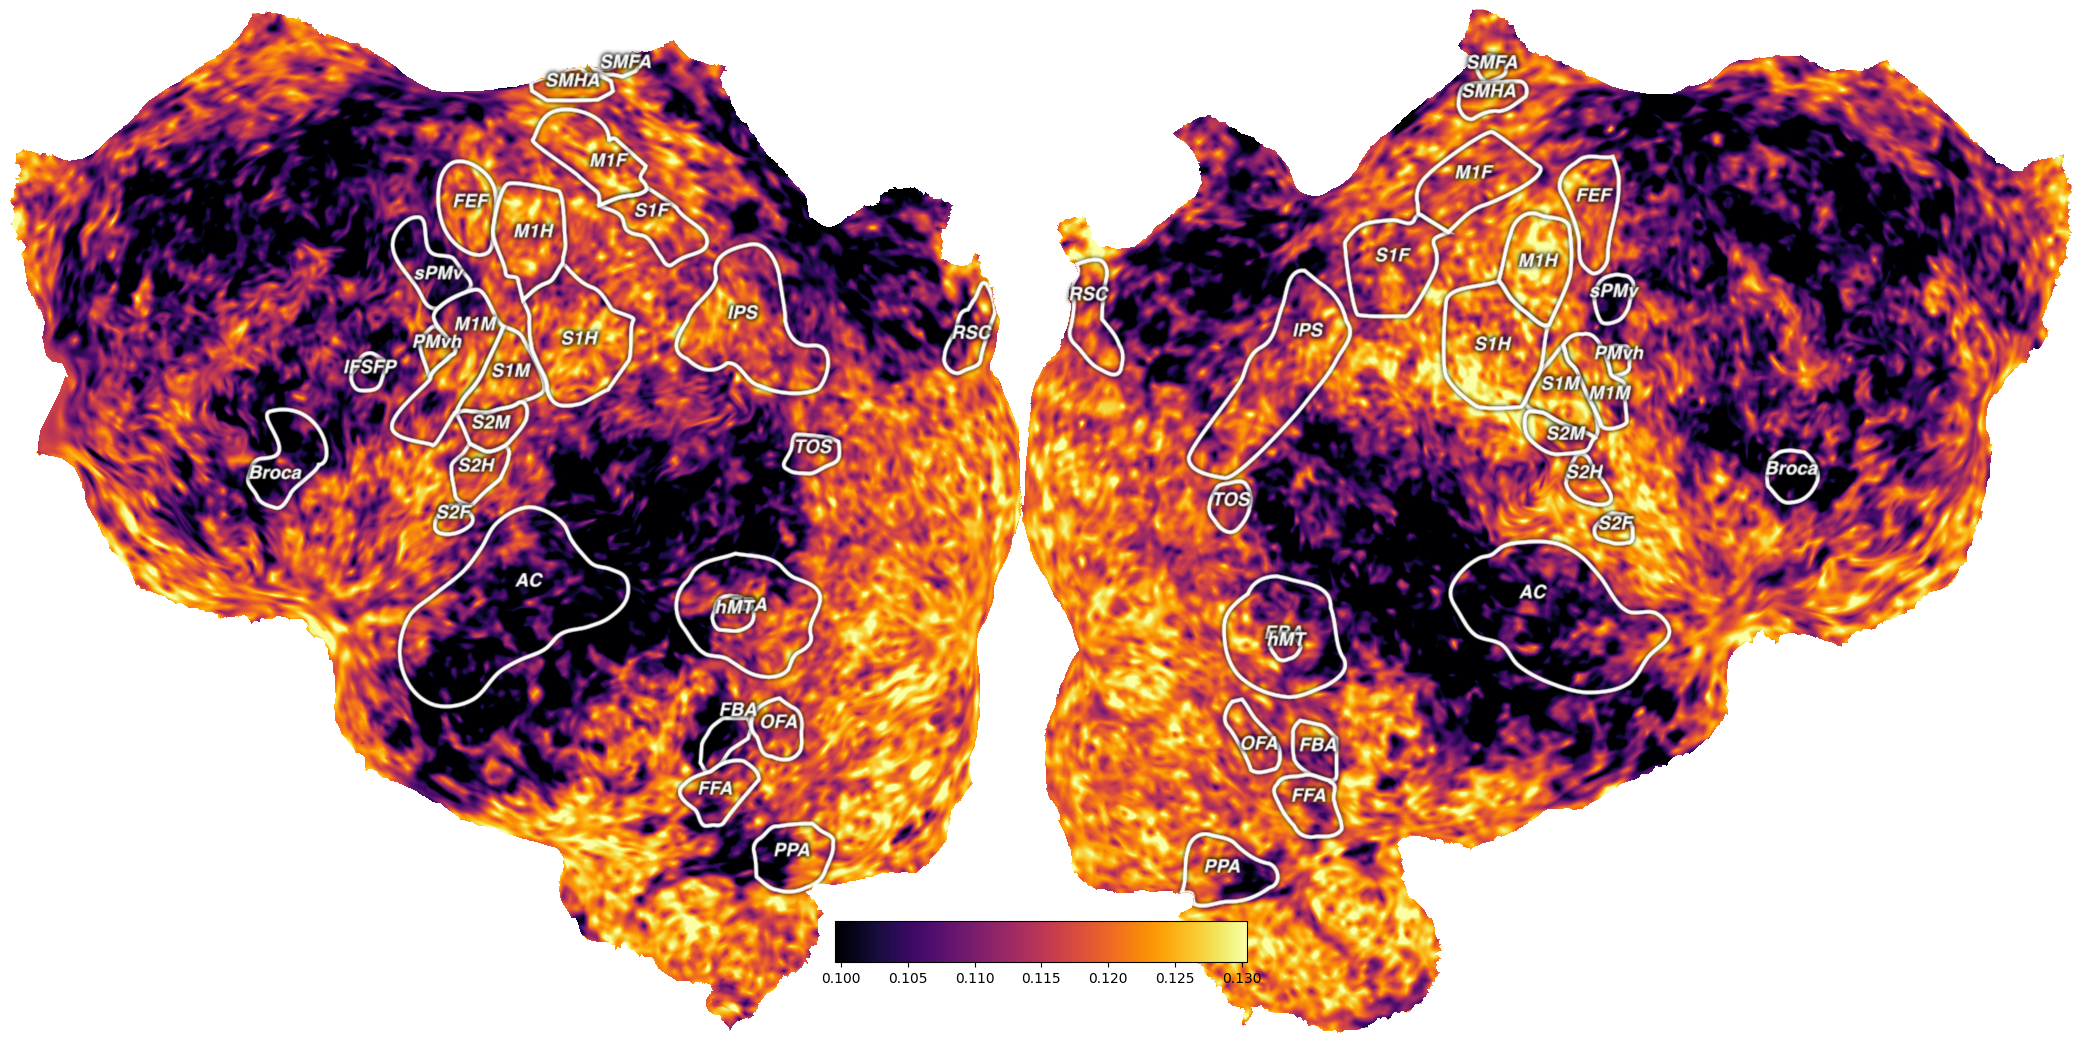

In [242]:
flatmap_kwargs = {'recache': False, 'pixelwise': True, 'sampler': 'trilinear',
    'height': 1024, 'with_rois': True, #'with_labels': False, 
    'with_curvature': True, 'curvature_threshold': True, 'linewidth': 4,
    'nanmean': True}

# Plot with pycortex
# get weighted average of frequency bins by coherence - find the center of mass of the coherence spectrum
vol_data = np.average(np.broadcast_to(freqs[:, None], coherence_upper.shape), weights=coherence_upper, axis=0) 
#vol_data[(coherence.mean(0) < 0.1) & (coherence.mean(0) > 0.13)] = np.nan # coherence threshold .09, should we filter out high frequency noise? 
#vol_data[coherence.mean(0) < 0.1] = np.nan # coherence threshold .09, should we filter out high frequency noise? 

vmin, vmax = np.nanpercentile(vol_data, [10, 100-10])
vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='inferno', vmin=vmin, vmax=vmax)
cortex.quickshow(vol, **flatmap_kwargs);

In [ ]:
cortex.webshow(vol, port=1420);

## 3. Disentangling PSD from SNR

#### 1) Plot center of mass (power) vs. SNR (coherence) for selected ROIs

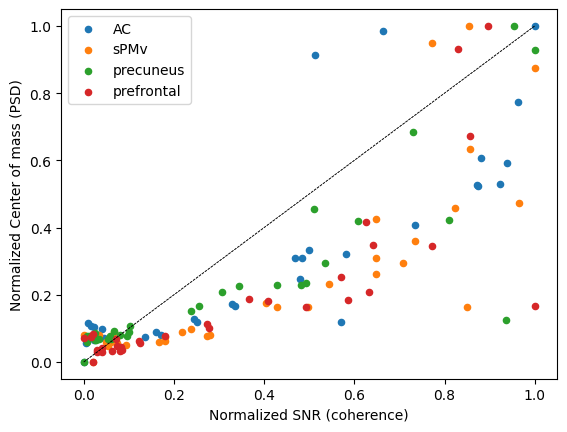

In [306]:
for roi in roi_voxs:
    mu_roi_pxx = np.mean(Pxx[:, roi_voxs[roi]], axis=1)
    ub_coherence_denoise = np.mean(coherence_upper_denoise[:, roi_voxs[roi]], axis=1)

    # Min-max normalization
    ub_coherence_norm = (ub_coherence_denoise - np.min(ub_coherence_denoise)) / (np.max(ub_coherence_denoise) - np.min(ub_coherence_denoise))
    mu_roi_pxx_norm = (mu_roi_pxx - np.min(mu_roi_pxx)) / (np.max(mu_roi_pxx) - np.min(mu_roi_pxx))

    plt.scatter(ub_coherence_norm, mu_roi_pxx_norm.T, label=roi, s=20)
    plt.plot([0,1],[0,1],color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    
plt.xlabel('Normalized SNR (coherence)')
plt.ylabel('Normalized Center of mass (PSD)')
plt.legend()
plt.show()
